In [1]:
def generate_continuous_plot_data (price_result, market_price, nominal=True):
    import numpy as np
    import pandas as pd
    
    '''
    price_result: one balance strategy only
    '''
    price_df_list = market_price
    
    plot_data_list = []
    
    # 1. Get Nominal Price Transaction Records
    trans_date_df = pd.DataFrame([tmp['Date']for tmp in price_result], columns = ['Date']) 
    # ^ Action dates in the five years
    trans_df_list = []

    for market_num in range(3): # nominal_df_list[0-2] for three assets
        asset_df = pd.DataFrame([tmp['Record'][market_num] for tmp in price_result]) 
        # ^ Get the asset weightage at each time
        result_df = pd.concat([trans_date_df, asset_df], axis=1)
        result_df.rename(columns={'0':'Date'}, inplace=True)
        trans_df_list.append(result_df)
    
    for market_num in range(3):
        tmp_trans_df = trans_df_list[market_num]
        trans_date = tmp_trans_df['Date']
        start_date = list(trans_date)[0]
        end_date = list(price_df_list[0]['Date'])[-1]

        history_df = price_df_list[market_num]
        all_price_date = history_df['Date'][(history_df['Date']>=start_date) & (history_df['Date']<= end_date)]
        plot_data = []
        number = 0
        net_value = 0
        price = 0
        for date in all_price_date:
            if (trans_date == date).any(): # If rebalanced at that day:
                number = tmp_trans_df['Number'][tmp_trans_df['Date']==date].values[0]
                net_value = tmp_trans_df['Net Value'][tmp_trans_df['Date']==date].values[0]
                price = tmp_trans_df['Price'][tmp_trans_df['Date']==date].values[0]
            else:
                if nominal:
                    price = history_df['Price'][history_df['Date']==date].values[0]
                else:
                    price = history_df['Actual Price'][history_df['Date']==date].values[0]

                net_value = number*price
            plot_data.append({
                "Date": date,
                "Number": number,
                "Price": price,
                "Net Value": net_value
            })
        plot_data_list.append(plot_data)
        
    return trans_df_list, plot_data_list

In [2]:
def generate_graph(nominal_plot_data_list, actual_plot_data_list, nominal_trans_df_list, actual_trans_df_list):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from matplotlib.gridspec import GridSpec
    from CSVUtils import csv2df

    DIR = "./from github/Stock-Trading-Environment/data"
    file_names = ["^BVSP", "^TWII", "^IXIC"]
    source_list = ["yahoo", "yahoo", "yahoo"] # for plotting price data

    nominal_labels = ["high risk-^BVSP_nominal", "mid risk-^TWII_nominal", "low risk-^IXIC"]
    actual_labels = ["high risk-^BVSP_actual", "mid risk-^TWII_actual", "low rick-^IXIC"]


    plt.rcParams['figure.facecolor'] = 'white'
    fig=plt.figure(figsize=(40,25))
    axs = []
    gs=GridSpec(5,1) # 5 rows, 1 columns
    axs.append(fig.add_subplot(gs[0,0])) # First row, first column
    axs.append(fig.add_subplot(gs[1,0])) # First row, second column
    axs.append(fig.add_subplot(gs[2,0])) # First row, third column
    axs.append(fig.add_subplot(gs[3:,:])) # Second row, span all columns
    
    init_net_value = np.sum([tmp['Net Value'][0] for tmp in actual_trans_df_list])/3
#     print(init_net_value)


    for i, plot_data in enumerate(nominal_plot_data_list):
        plot_data = pd.DataFrame(plot_data)

#         axs[i].plot(plot_data['Date'], np.log(plot_data['Net Value']/plot_data['Net Value'][0]), 
#                     color="C0", label = nominal_labels[i]+"_Log Market Value")
#         axs[i].bar(nominal_trans_df_list[i]['Date'], np.log(nominal_trans_df_list[i]['Net Value']/nominal_trans_df_list[i]['Net Value'][0]), 
        axs[i].bar(nominal_trans_df_list[i]['Date'], np.log(nominal_trans_df_list[i]['Net Value']/init_net_value), 
                   width=2, color="C0")
#         axs[i].plot(nominal_trans_df_list[i]['Date'], np.log(nominal_trans_df_list[i]['Net Value']/nominal_trans_df_list[i]['Net Value'][0]), 
        axs[i].plot(nominal_trans_df_list[i]['Date'], np.log(nominal_trans_df_list[i]['Net Value']/init_net_value), 
                    linestyle='--', color="C0", label = nominal_labels[i]+"_Log Book Value")

        axs[i].axhline(y=0, color = "grey", linestyle='--')
        axs[i].legend()
        axs[i].set_title('Portfolio Weights')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Market Value (US$)')


    for i, plot_data in enumerate(actual_plot_data_list):
        plot_data = pd.DataFrame(plot_data)

#         axs[i].plot(plot_data['Date'], np.log(plot_data['Net Value']/plot_data['Net Value'][0]), 
#                     color="orange", label = actual_labels[i]+"_Log Market Value")
#         axs[i].bar(actual_trans_df_list[i]['Date'], np.log(actual_trans_df_list[i]['Net Value']/actual_trans_df_list[i]['Net Value'][0]), 
        axs[i].bar(actual_trans_df_list[i]['Date'], np.log(actual_trans_df_list[i]['Net Value']/init_net_value), 
                   width=2, color="orange")

        axs[i].plot(actual_trans_df_list[i]['Date'], np.log(actual_trans_df_list[i]['Net Value']/init_net_value), 
                    linestyle='--', color="orange", label = actual_labels[i]+"_Log Book Value")
        axs[i].plot(price_df_list[i]['Date'], np.log(price_df_list[i]['Cum FX Change']),
                    color="green", linestyle='--', label = nominal_labels[i]+"_Log FX Change")


        axs[i].axhline(y=0, color = "grey", linestyle='--')
    #     axs[i].set_ylim((0, 300000))
        axs[i].set_title('Log Portfolio Value')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Log Value')



    for i in range(2,-1,-1): # Inverse: Low-Mid-High
        df = csv2df(DIR, file_names[i]+".csv",source = source_list[i])
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[(df['Date']>=pd.to_datetime("2015-01-01"))&(df['Date']<=pd.to_datetime("2019-12-31"))].reset_index(drop=True)

        j = 0
        init_price = df['Price'][j]
        while np.isnan(init_price):
            j+=1
            init_price = df['Price'][j]
        y = np.log(df['Price'][j:] / init_price)
        x = df['Date'][j:]
        axs[3].plot(x,y,label = nominal_labels[i])
        axs[i].plot(x,y, color = "pink", linestyle='--', label = nominal_labels[i]+"_Log Nominal Price")
        axs[i].legend()

    axs[3].axhline(y=0, color = "grey", linestyle='--')
    # axs[3].set_ylim((-1,1))
    axs[3].legend()
    axs[3].set_title('Log Market Price')
    axs[3].set_xlabel('Date')
    axs[3].set_ylabel('log(Market Price)')
    plt.show()

In [3]:
def plot_rebalance_record(nominal_price_result, actual_price_result, market_price):
    '''
    rebalance_record = [nominal_price_result, actual_price_result];
    nominal_price_resul[0-3]: The Transaction Records for evenly rebalancing the portfolio for [1 year, 6 months, 3 months, 1 month], REGARDLESS of Commission Cost and FX Change;
    actual_price_result[0-3]: The Transaction Records for evenly rebalancing the portfolio for [1 year, 6 months, 3 months, 1 month], CONSIDERING of Commission Cost and FX Change;
    
    price_df_list[0-2]: The History data for three indexes [^BVSP, ^TWII, ^IXIC] within a given range, with:
    Nominal Price['Price'], and Actual Price ['Actual Price'], where the Cummulative FX Change ['Cum FX Change'] is considered
    '''
    
    nominal_trans_df_list, nominal_plot_data_list = generate_continuous_plot_data(nominal_price_result, market_price, nominal=True)
    actual_trans_df_list, actual_plot_data_list = generate_continuous_plot_data(actual_price_result, market_price, nominal=False)

    generate_graph(nominal_plot_data_list, actual_plot_data_list, nominal_trans_df_list, actual_trans_df_list)

In [4]:
import pickle

tmp = pickle.load(open("0306-currency adjusted rebalance record.out", "rb"))
nominal_price_result = tmp[0][3] # Six Months
actual_price_result = tmp[1][3]
price_df_list = pickle.load(open("0306-adjusted market prices.out", "rb"))

plot_rebalance_record(nominal_price_result, actual_price_result, price_df_list)

/Users/lzcai/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 4000x2500 with 4 Axes>

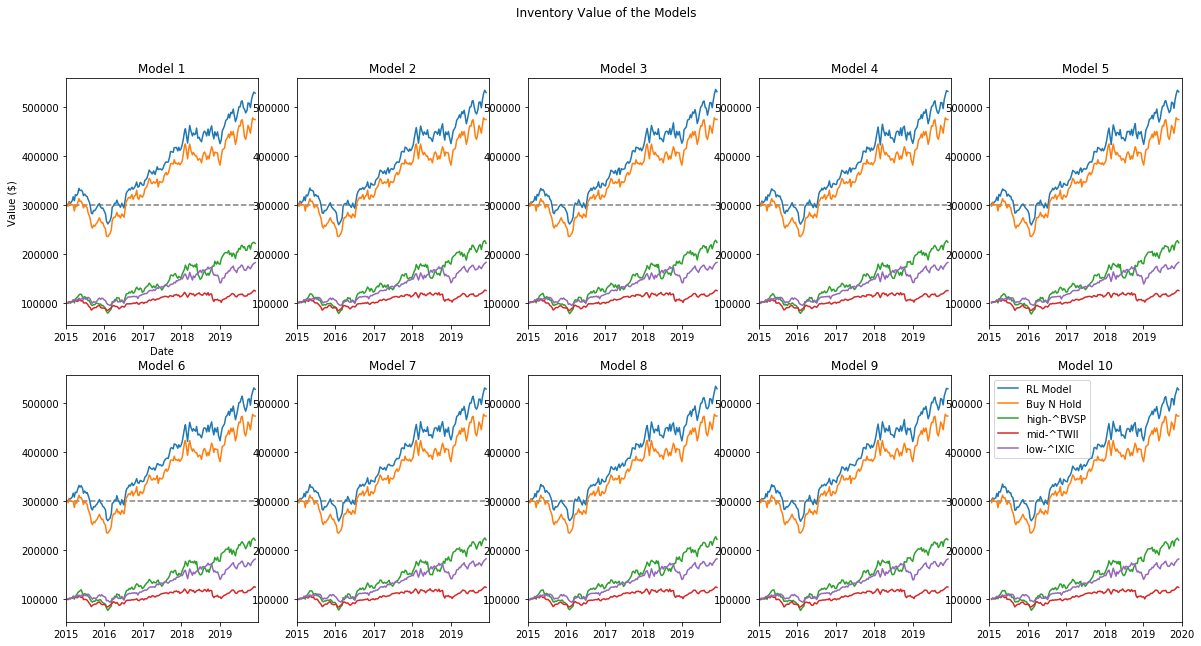

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
import pickle

output_dir = "./from github/Stock-Trading-Environment/output/300"
axx = plt.figure(figsize=(20,10))
plt.suptitle("Inventory Value of the Models")
plt.rcParams['figure.facecolor'] = 'white'
# legend_list = ['S&P 500', 'Germany Dax', 'Hang Seng', 'CASH']
labels = ["high-^BVSP", "mid-^TWII", "low-^IXIC"]
for i in range(10):
    try:
        if i == 0:
            ax0 = plt.subplot(2, 5, 1)
            plt.xlabel("Date")
            plt.ylabel("Value ($)")
            ax = ax0
        else:
            ax = plt.subplot(2, 5, i+1, sharex=ax0, sharey = ax0)
        
        record = pickle.load(open(path.join(output_dir,"BRZ_TW_NASDAQ-MultiRewardWithLeakage-7d_detailed-ModelNo-100000-"+str(i)+".out"), "rb"))
        df = pd.DataFrame(record)
#         plt.axhline(y=0, color = "grey", linestyle='--')
        plt.axhline(y=300000, color = "grey", linestyle='--')
        plt.xlim((pd.Timestamp('2015-01-01'),pd.Timestamp('2019-12-31')))
        ax.set_xticks([pd.Timestamp('2015-01-01'), pd.Timestamp('2016-01-01'), 
                       pd.Timestamp('2017-01-01'), pd.Timestamp('2018-01-01'),
                       pd.Timestamp('2019-01-01'), pd.Timestamp('2020-01-01')])
        plt.plot(df['date'], df['net_worth'], label="RL Model")
        plt.plot(df['date'], df['buyNhold_balance'], label="Buy N Hold")
        
        for j in range(3):
            plt.plot(df['date'], [tmp[j] for tmp in df['inventory']], label=labels[j])
#             first_price = df['actual_price'][0][j]
#             plt.plot(df['date'], [tmp[j]/first_price*300000 for tmp in df['actual_price']])
        plt.title("Model "+str(i+1))
    except Exception as e:
        print(e)
plt.legend()

In [13]:
from os import path
import numpy as np
import pandas as pd
import pickle

output_dir = "./from github/Stock-Trading-Environment/output/305"
record = pickle.load(open(path.join(output_dir,"BRZ_TW_NASDAQ-Selected_Trans-withleakage+RSI-_detailed-ModelNo-10000-9.out"), "rb"))
df = pd.DataFrame(record)

In [14]:
asset_list = ["^BVSP", "^TWII", "^IXIC"]
actual_price_result = []
prev_num = [0,0,0]
for _, record in df.iterrows():
    status_list = []
    
    for i, asset in enumerate(asset_list):
        status = {
            'Asset': asset_list[i],
            'Number': record['shares_held'][i],
            'Price': record['actual_price'][i],
            'Net Value': record['shares_held'][i]*record['actual_price'][i],
            'Delta Number': record['shares_held'][i] - prev_num[i]
        }
        status_list.append(status)
        prev_num[i] = record['shares_held'][i]
    
    actual_price_result.append({
        'Date': record['date'],
        'Record': status_list
    })

In [15]:
price_df_list = pickle.load(open("0306-adjusted market prices.out", "rb"))

In [16]:
asset_list = ["^BVSP", "^TWII", "^IXIC"]
nominal_price_result = []
prev_num = [0,0,0]
for _, record in df.iterrows():
    status_list = []
    
    for i, asset in enumerate(asset_list):
        nominal_price = float(price_df_list[i][price_df_list[i]['Date']==record['date']]['Price'])
        status = {
            'Asset': asset_list[i],
            'Number': record['shares_held'][i],
            'Price': nominal_price,
            'Net Value': record['shares_held'][i]*nominal_price,
            'Delta Number': record['shares_held'][i] - prev_num[i]
        }
        status_list.append(status)
        prev_num[i] = record['shares_held'][i]
    
    nominal_price_result.append({
        'Date': record['date'],
        'Record': status_list
    })

In [22]:
nominal_trans_df_list, nominal_plot_data_list = generate_continuous_plot_data(nominal_price_result, price_df_list, nominal=True)

In [27]:
nominal_trans_df_list[0]

,Date,Asset,Number,Price,Net Value,Delta Number
0,2015-01-13,^BVSP,2.081512,48042.0,100000.000000,2.081512
1,2015-01-14,^BVSP,2.081512,47646.0,99175.721244,0.000000
2,2015-01-15,^BVSP,2.081512,48026.0,99966.695808,0.000000
3,2015-01-16,^BVSP,2.081512,49017.0,102029.474210,0.000000
4,2015-01-20,^BVSP,2.081512,47877.0,99656.550518,0.000000
5,2015-01-21,^BVSP,2.081512,49224.0,102460.347196,0.000000
6,2015-01-22,^BVSP,2.081512,49443.0,102916.198326,0.000000
7,2015-01-23,^BVSP,2.081512,48775.0,101525.748304,0.000000
8,2015-01-26,^BVSP,2.081512,48577.0,101113.608926,0.000000
9,2015-01-27,^BVSP,2.081512,48591.0,101142.750094,0.000000


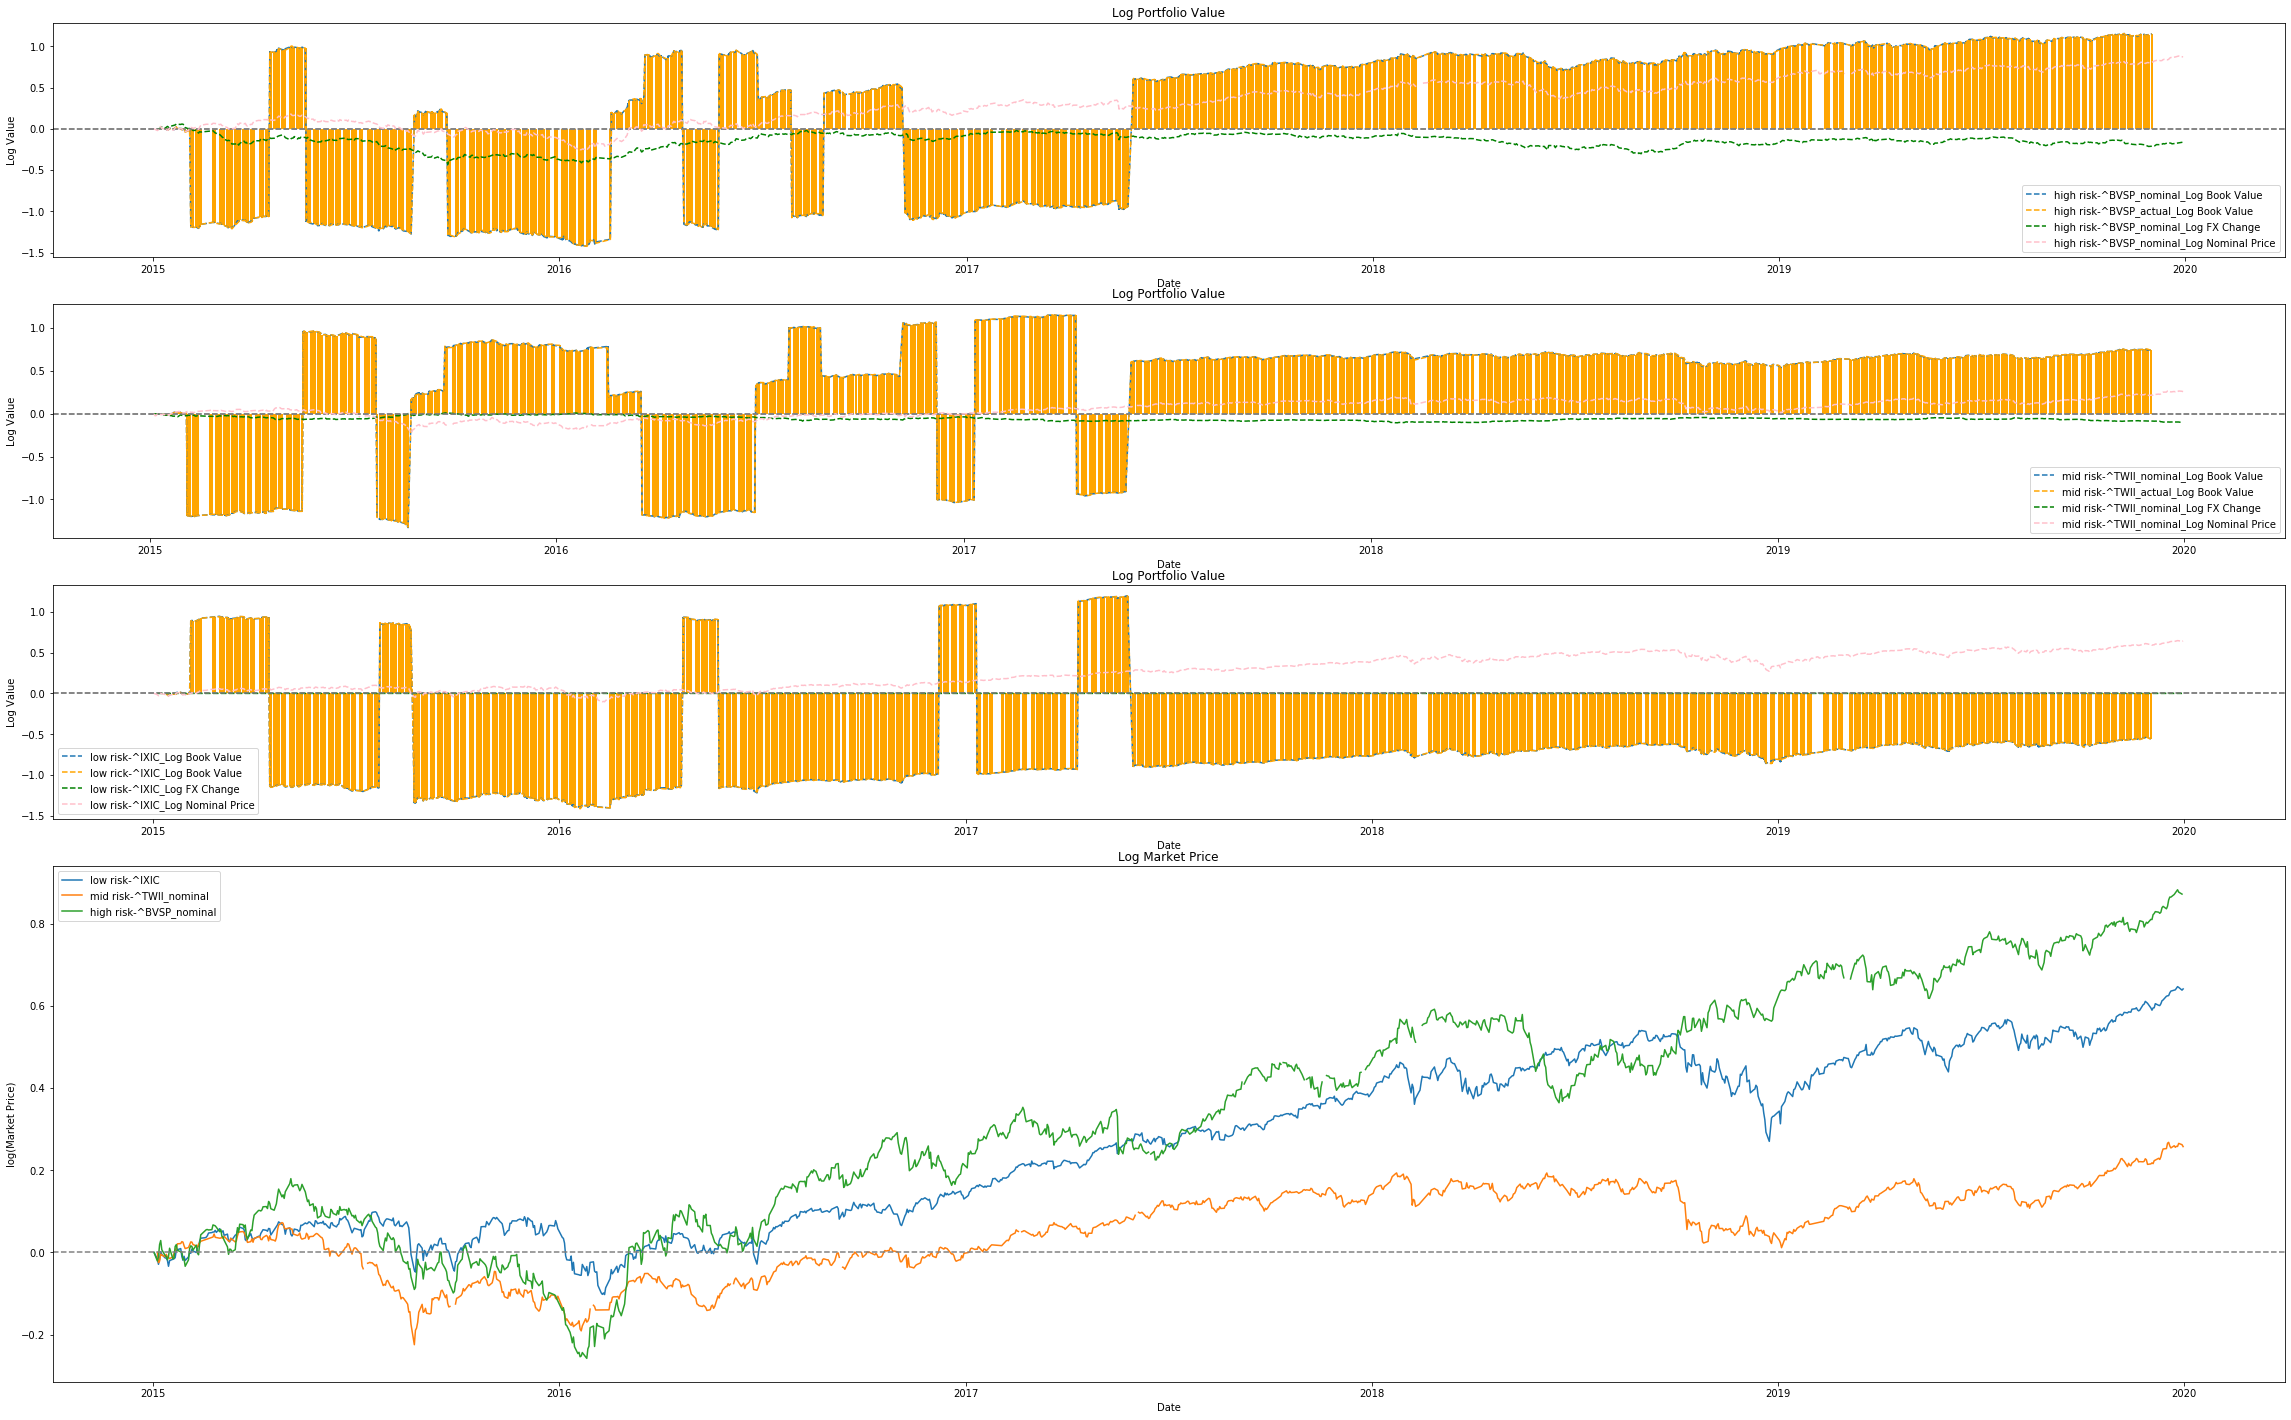

In [17]:
import numpy as np
plot_rebalance_record(nominal_price_result, actual_price_result, price_df_list)

In [18]:
nominal_price_result

[{'Date': Timestamp('2015-01-13 00:00:00'),
  'Record': [{'Asset': '^BVSP',
    'Number': 2.0815120103242997,
    'Price': 48042.0,
    'Net Value': 100000.0,
    'Delta Number': 2.0815120103242997},
   {'Asset': '^TWII',
    'Number': 10.832164080205406,
    'Price': 9231.765625,
    'Net Value': 100000.0,
    'Delta Number': 10.832164080205406},
   {'Asset': '^IXIC',
    'Number': 21.452322213879654,
    'Price': 4661.5,
    'Net Value': 100000.00000000001,
    'Delta Number': 21.452322213879654}]},
 {'Date': Timestamp('2015-01-14 00:00:00'),
  'Record': [{'Asset': '^BVSP',
    'Number': 2.0815120103242997,
    'Price': 47646.0,
    'Net Value': 99175.72124391158,
    'Delta Number': 0.0},
   {'Asset': '^TWII',
    'Number': 10.832164080205406,
    'Price': 9180.196289,
    'Net Value': 99441.39249094075,
    'Delta Number': 0.0},
   {'Asset': '^IXIC',
    'Number': 21.452322213879654,
    'Price': 4639.319824,
    'Net Value': 99524.18371768745,
    'Delta Number': 0.0}]},
 {'Date':

In [19]:
actual_price_result

[{'Date': Timestamp('2015-01-13 00:00:00'),
  'Record': [{'Asset': '^BVSP',
    'Number': 2.0815120103242997,
    'Price': 48788.623379091965,
    'Net Value': 101554.10553076884,
    'Delta Number': 2.0815120103242997},
   {'Asset': '^TWII',
    'Number': 10.832164080205406,
    'Price': 9226.427917935018,
    'Net Value': 99942.18108126005,
    'Delta Number': 10.832164080205406},
   {'Asset': '^IXIC',
    'Number': 21.452322213879654,
    'Price': 4705.719039414923,
    'Net Value': 100948.60108151718,
    'Delta Number': 21.452322213879654}]},
 {'Date': Timestamp('2015-01-14 00:00:00'),
  'Record': [{'Asset': '^BVSP',
    'Number': 2.0815120103242997,
    'Price': 47711.11542045572,
    'Net Value': 99311.25977364747,
    'Delta Number': 0.0},
   {'Asset': '^TWII',
    'Number': 10.832164080205406,
    'Price': 9237.13016537568,
    'Net Value': 100058.10958156426,
    'Delta Number': 0.0},
   {'Asset': '^IXIC',
    'Number': 21.452322213879654,
    'Price': 4599.1921974648785,
   